In [1]:
%pip install tensorflow keras transformers torch nltk plotly cufflinks wordcloud keras-tuner chart-studio tf-keras accelerate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import required libraries
import tensorflow as tf
from tensorflow.keras.layers import LSTM
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from transformers import DistilBertForSequenceClassification
from keras.layers import Concatenate
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras import layers
from keras.callbacks import *
from keras.layers import *
from keras.models import Sequential,Model
import accelerate, torch
import kerastuner as kt
from transformers import TrainingArguments, Trainer

import transformers
from transformers import AutoTokenizer, TFAutoModel
from transformers import AutoConfig, AutoModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud,STOPWORDS
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%pip install chart_studio
from IPython.display import HTML
import plotly
import cufflinks
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import iplot
from plotly.subplots import make_subplots

plotly.offline.init_notebook_mode(connected=True)
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from string import punctuation
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

C:\Users\user\AppData\Local\Temp\ipykernel_14036\1092501702.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt



Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [3]:
# load the three datasets
df_cleaned_1 = pd.read_csv('./Preprocessed_Dataset_1.csv')
df_cleaned_2 = pd.read_csv('./Preprocessed_Dataset_2.csv')
df_cleaned_3 = pd.read_csv('./Preprocessed_Dataset_3.csv')

In [4]:
# Define a function for text preprocessing
def preprocess_data(df):
    # Initialize the Tokenizer to process the text data
    # num_words=10000: Only consider the top 10,000 words in the text corpus
    # oov_token="<OOV>": Specify the token for out-of-vocabulary words 
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    
    # Fit the tokenizer on the 'Cleaned_text' column, which should contain preprocessed text
    tokenizer.fit_on_texts(df['Cleaned_text'])
    
    # Convert the texts into sequences of integers based on the tokenizer's word index
    sequences = tokenizer.texts_to_sequences(df['Cleaned_text'])
    
    # Pad the sequences to ensure they all have the same length
    # maxlen=100 truncates any sequences longer than 100 words and pads shorter ones to a length of 100
    X = pad_sequences(sequences, padding='post', maxlen=100)
    
    # Define the target variable 
    y = df['target']
    
    # Return the padded sequences (X), the target labels (y), and the tokenizer (so it can be used for future data)
    return X, y, tokenizer

# Preprocess data for each dataset
X1, y1, tokenizer_1 = preprocess_data(df_cleaned_1)  # Preprocess first dataset
X2, y2, tokenizer_2 = preprocess_data(df_cleaned_2)  # Preprocess second dataset
X3, y3, tokenizer_3 = preprocess_data(df_cleaned_3)  # Preprocess third dataset

# Split the data into training and testing sets (80% training, 20% testing)
# Dataset-1 splitting
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
# Dataset-2 splitting
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
# Dataset-2 splitting
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [5]:
# Define a function to create the RNN model
def create_rnn_model():
    #Initialize a Sequential model
    model = Sequential()

    #Embedding Layer
    # Add an Embedding layer to convert the input integer sequences into dense word embeddings
    # input_dim=10000: Specifies the vocabulary size (top 10,000 words)
    # output_dim=64: The size of the embedding vectors (64-dimensional vectors)
    # input_length=100: Specifies the length of the input sequences (100 words per sequence)
    model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))

    # Add the first RNN layer to capture temporal dependencies in the sequence
    model.add(SimpleRNN(128, return_sequences=True)) 

    # Add a Dropout layer with 50% probability to prevent overfitting during training
    model.add(Dropout(0.5))

    # Add the second RNN layer to further reduce the dimensionality of the output to a 64-dimensional vector
    model.add(SimpleRNN(64))

    # Add another Dropout layer with 50% probability to further reduce overfitting
    model.add(Dropout(0.5))

    # Add a Dense layer with activation='sigmoid' (ensures the output is a probability between 0 and 1)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model using the Adam optimizer and binary crossentropy loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'f1_score'])

    return model

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot confusion matrix using seaborn heatmap
def plot_confusion_matrix(cm, labels):
    """Plot confusion matrix using seaborn heatmap"""
    # Set up the plot figure with specific size
    plt.figure(figsize=(6, 5))
    
    # Use seaborn to plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    
    # Add labels and title to the plot
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    
    # Show the plot
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, auc_score):
    """Plot the ROC curve"""
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Function to train the model, evaluate performance, and visualize results
def train_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """Train deep learning model, evaluate performance, and visualize results"""
    
    # Define early stopping to avoid overfitting.
    early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

    # Train the model
    history = model.fit(
        # Model Parameters
        X_train, y_train,  
        epochs=10,  
        batch_size=32, 
        validation_data=(X_test, y_test),  # Validation data for evaluation during training
        callbacks=[early_stop],  # Early stopping to prevent overfitting
        verbose=1  # Show progress bar during training
    )
    
    # Generate predictions for the test set (threshold at 0.5 for binary classification)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    
    # Calculate accuracy score based on predictions
    acc = accuracy_score(y_test, y_pred)
    
    # Calculate weighted F1-score (useful for imbalanced classes)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    # Generate a classification report for a detailed performance summary
    class_report = classification_report(y_test, y_pred)
    
    # Compute confusion matrix to visualize the classification performance
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))  # Model predicts probabilities
    auc_score = auc(fpr, tpr)

    # Store relevant metrics in a dictionary
    metrics = {
        "Model": model_name,  # Store the model name
        "Accuracy": acc,  # Store the accuracy value
        "F1-score": f1,  # Store the F1-score
        "AUC": auc_score  # Store the AUC score
    }

    # Print the model performance results
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print("\nClassification Report:\n", class_report)

    # Plot the confusion matrix to visualize the classification results
    plot_confusion_matrix(conf_matrix, labels=["Non-Disaster", "Disaster"])

    # Plot the ROC curve
    plot_roc_curve(fpr, tpr, auc_score)

    # Return training history and computed metrics for further analysis or reporting
    return history, metrics

In [9]:
# Train RNN model for Dataset 1
# Create an RNN model using the previously defined 'create_rnn_model' function
rnn_model = create_rnn_model()


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.5154 - f1_score: 0.5904 - loss: 0.7854 - val_accuracy: 0.5407 - val_f1_score: 0.5931 - val_loss: 0.6888
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.5055 - f1_score: 0.6048 - loss: 0.7786 - val_accuracy: 0.4216 - val_f1_score: 0.5931 - val_loss: 0.7271
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.5143 - f1_score: 0.6043 - loss: 0.7315 - val_accuracy: 0.5797 - val_f1_score: 0.5931 - val_loss: 0.6868
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5157 - f1_score: 0.5977 - loss: 0.7134 - val_accuracy: 0.5804 - val_f1_score: 0.5931 - val_loss: 0.6836
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.5454 - f1_score: 0.6000 - loss: 0.6920 - val_accuracy: 0.5784 - val_f1_score: 0.5931 - val_loss: 0.6913
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.5289 - f1_score: 0.6033 - loss: 0.6956 - val_accuracy: 0.5784 - val_f1_s

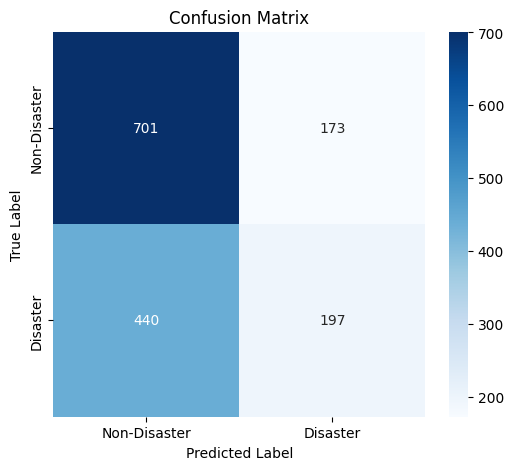

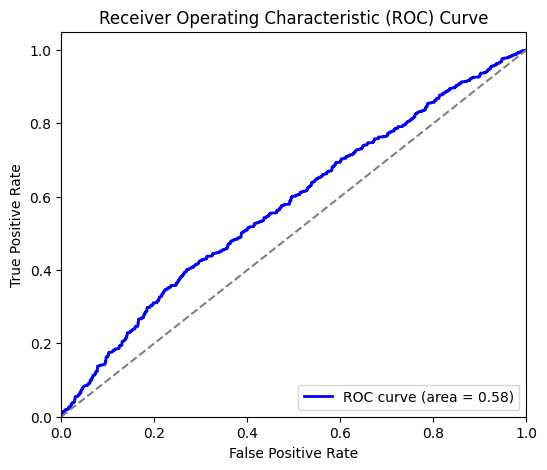

In [10]:
# Train the RNN model for Dataset 1
history_rnn, rnn_metrics = train_model(rnn_model, X_train_1, y_train_1, X_test_1, y_test_1, model_name="RNN")

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5521 - f1_score: 0.8114 - loss: 0.6805 - val_accuracy: 0.7049 - val_f1_score: 0.8269 - val_loss: 0.6126
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.5761 - f1_score: 0.8313 - loss: 0.6876 - val_accuracy: 0.7063 - val_f1_score: 0.8269 - val_loss: 0.6008
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7280 - f1_score: 0.8252 - loss: 0.5960 - val_accuracy: 0.7091 - val_f1_score: 0.8269 - val_loss: 0.6057
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7266 - f1_score: 0.8255 - loss: 0.5893 - val_accuracy: 0.7091 - val_f1_score: 0.8269 - val_loss: 0.6038
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

RNN Performance:
Accuracy: 0.7063
F1-score: 0.5936
AUC: 0.5435

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.02      0.04       211
           1       0.71      0.99      0.83   

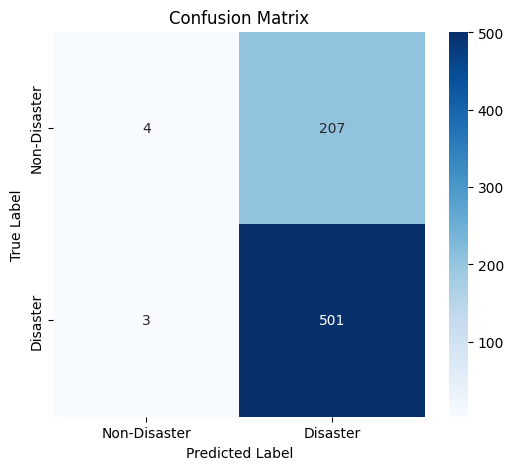

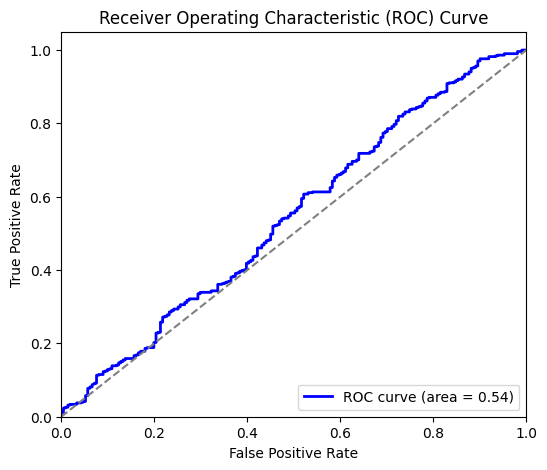

In [11]:

# Train the RNN model for Dataset 2
history_rnn, rnn_metrics = train_model(rnn_model, X_train_2, y_train_2, X_test_2, y_test_2, model_name="RNN")

In [ ]:
# Train the RNN model for Dataset 3
history_rnn, rnn_metrics = train_model(rnn_model, X_train_3, y_train_3, X_test_3, y_test_3, model_name="RNN")